## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [ ]:
'''
I used the 'Phishing_clean.parquet' file in the same directory as the assignment
jupyter notebook for this assignment. I am assuming that this data has already
been cleaned.
'''

In [5]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_parquet('Phishing_clean.parquet')

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [6]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

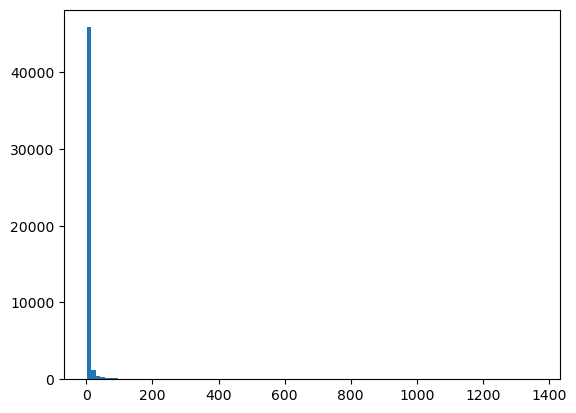

In [7]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [10]:
# Separate features and target variable
X = data.drop(columns=['Email Type'])
y = data['Email Type']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression on one-hot-encoded emails
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions and R^2
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R^2 on Training Set: {r2_train:.4f}")
print(f"R^2 on Test Set: {r2_test:.4f}")

# Coefficients of the model
coefficients = pd.DataFrame({'Token': X.columns, 'Coefficient': lr.coef_})
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
top_tokens = coefficients.sort_values(by='Absolute Coefficient', ascending=False).head(10)

print("Top 10 Tokens with the Largest Coefficients:")
print(top_tokens)

R^2 on Training Set: 0.7667
R^2 on Test Set: -71409659288640842366976.0000
Top 10 Tokens with the Largest Coefficients:
            Token   Coefficient  Absolute Coefficient
340          2005  1.542063e+13          1.542063e+13
1557         2003  1.270139e+13          1.270139e+13
1723          3rd  8.376358e+12          8.376358e+12
1014         8859 -7.933070e+12          7.933070e+12
710          1997 -7.856927e+12          7.856927e+12
1302     erectile  6.910391e+12          6.910391e+12
1269  dysfunction -6.910391e+12          6.910391e+12
6            2002 -6.614847e+12          6.614847e+12
497           713 -6.234337e+12          6.234337e+12
318           100  5.917795e+12          5.917795e+12


In [ ]:
'''
Most of the top tokens are just numbers, which is disappointing to see.
However, there are two words: erectile and dysfunction. I am assumming that
these two words are usually together in these phishing emails. Definitely a
way to grab the email readers' attention.
'''

### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

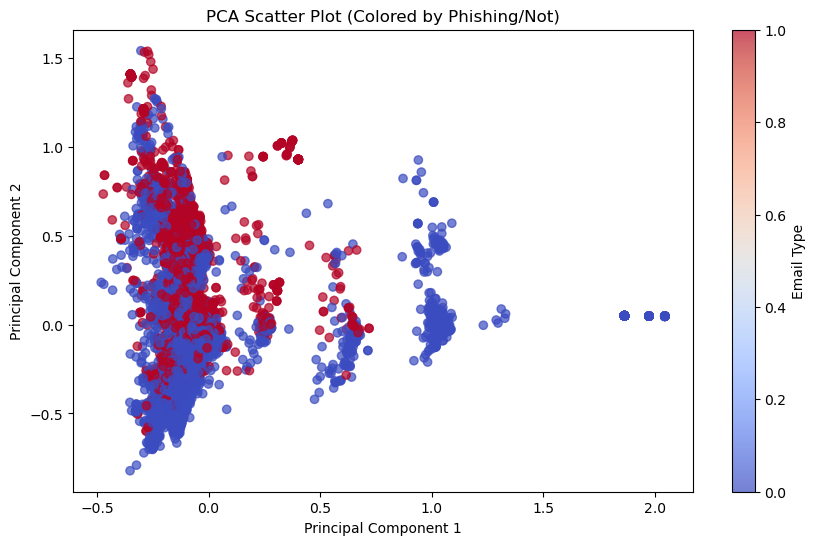

In [15]:
# Step 3: Principal Components Analysis (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Scatter plot of first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot (Colored by Phishing/Not)')
plt.colorbar(label='Email Type')
plt.show()

In [ ]:
'''
The red dots represent the phishing emails. It seems like they usually have
a higher second component and lower first component.
'''

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [16]:
# PCA with 2,610 components
pca_full = PCA(n_components=2610)
X_train_pca = pca_full.fit_transform(X_train)
X_test_pca = pca_full.transform(X_test)

# Linear regression on PCA-transformed data
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

y_train_pca_pred = lr_pca.predict(X_train_pca)
y_test_pca_pred = lr_pca.predict(X_test_pca)

r2_train_pca = r2_score(y_train, y_train_pca_pred)
r2_test_pca = r2_score(y_test, y_test_pca_pred)

print(f"PCA Regression R^2 on Training Set: {r2_train_pca:.4f}")
print(f"PCA Regression R^2 on Test Set: {r2_test_pca:.4f}")

PCA Regression R^2 on Training Set: 0.7662
PCA Regression R^2 on Test Set: 0.6683


In [ ]:
'''
PCA regression performs better than the simple linear regression. The R^2 value 
is not close to zero and is closer to the training R^2 value.
'''

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

In [ ]:
'''Principal components condense the information from many variables into a smaller number of uncorrelated components, making the model easier to interpret and computationally 
efficient. Original variables might be highly correlated, which can make regression unstable. Principal components are uncorrelated, so they resolve this issue. However, there are 
drawbacks. Principal components are linear combinations of original variables, so their meaning is less intuitive compared to using the original data. If too few components are 
used, some important variation in the data might be excluded, reducing predictive accuracy.'''